In [4]:
import os
import json
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, brier_score_loss
from datasets import DatasetDict
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from glob import glob
from torch.utils.data import DataLoader

import torch.nn.functional as F

# Configuración de dispositivo (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

'cuda'

In [5]:
# @title Customize your key variables here
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 32 # @param {type:"integer"}
VALID_BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 4 # @param {type:"integer"}
LEARNING_RATE = 1e-5 # @param {type:"number"}

In [6]:
machines_files = glob('../data/machine/*.jsonl')
len(machines_files)

13

In [7]:
df_ids = pd.read_json('../data/human.jsonl', lines=True)
df_ids = df_ids[['id']]
df_ids["id"] = df_ids["id"].str.split('/').str[1:].str.join('/')
df_ids

,id
0,news-2021-01-01-2021-12-31-bideninauguration/a...
1,news-2021-01-01-2021-12-31-bideninauguration/a...
2,news-2021-01-01-2021-12-31-bideninauguration/a...
3,news-2021-01-01-2021-12-31-bideninauguration/a...
4,news-2021-01-01-2021-12-31-bideninauguration/a...
...,...
1082,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1083,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1084,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1085,news-2021-01-01-2021-12-31-wyominggabbypetito/...


In [8]:
train_ids_df, temp_df = train_test_split(df_ids, test_size=0.3, random_state=42)
val_ids_df, test_ids_df = train_test_split(temp_df, test_size=1/3, random_state=42)

train_ids_df.shape, val_ids_df.shape, test_ids_df.shape

((760, 1), (218, 1), (109, 1))

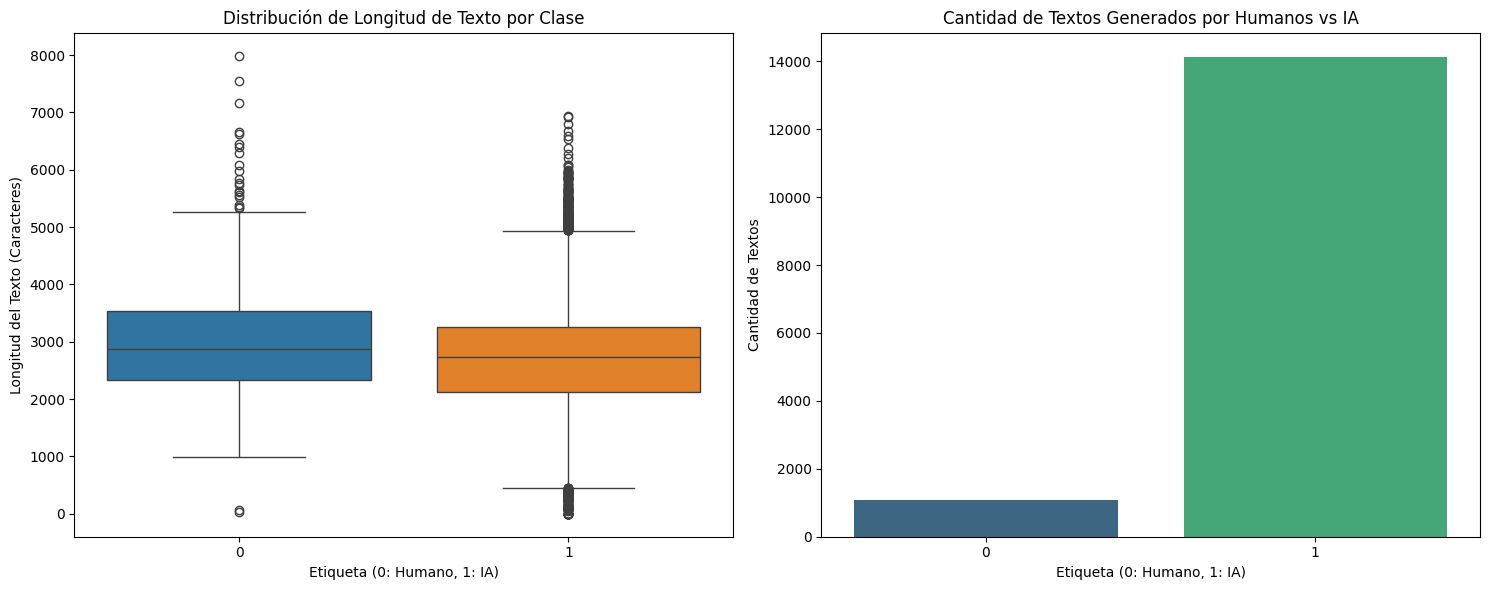

In [9]:
df_human = pd.read_json('../data/human.jsonl', lines=True)

df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1


df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

# Calcular la longitud del texto en la columna 'text'
df_temp["text_length"] = df_temp["text"].apply(len)

# Crear una figura con 2 subgráficos (uno al lado del otro)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de la longitud del texto (sin `palette`)
sns.boxplot(data=df_temp, x="label", hue="label",y="text_length", ax=ax[0], legend=False)
ax[0].set_title("Distribución de Longitud de Texto por Clase")
ax[0].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[0].set_ylabel("Longitud del Texto (Caracteres)")

# 2. Gráfico de la cantidad de texto generado por IA y Humanos
sns.countplot(data=df_temp, x="label", hue="label", palette="viridis", ax=ax[1], legend=False)
ax[1].set_title("Cantidad de Textos Generados por Humanos vs IA")
ax[1].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[1].set_ylabel("Cantidad de Textos")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [10]:
df_human["id"] = df_human["id"].str.split('/').str[1:].str.join('/')
df_machine["id"] = df_machine["id"].str.split('/').str[1:].str.join('/')

df_combined = pd.merge(df_human, df_machine, on="id", suffixes=("_1", "_2"))
df_combined['target_human'] = 1
df_combined['target_machine'] = 0
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine']]
df_combined

,id,text_1,target_human,text_2,target_machine
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Inaugural Address: President Joseph R. Biden J...,0
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address: A Clarion Call for ...,0
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0
...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Long Island Surf Shop Owner Reme...,0
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Super Kind-Heart...,0


In [11]:
random_indices = df_combined.sample(frac=0.5, random_state=42).index
df_combined.loc[random_indices, ['text_1', 'text_2']] = df_combined.loc[random_indices, ['text_2', 'text_1']].values
df_combined.loc[random_indices, ['target_human']] = 0
df_combined.loc[random_indices, ['target_machine']] = 1
df_combined['target_tuple'] = list(zip(df_combined['target_human'], df_combined['target_machine']))
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine', 'target_tuple']]
df_combined

,id,text_1,target_human,text_2,target_machine,target_tuple
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address: President Joseph R. Biden J...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0,"(1, 0)"
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0,"(1, 0)"
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Biden's Inaugural Address: A Clarion Call for ...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0,"(1, 0)"
...,...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito: Long Island Surf Shop Owner Reme...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0,"(1, 0)"
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0,"(1, 0)"
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito Remembered as a 'Super Kind-Heart...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"


In [12]:
X_train = df_combined[df_combined['id'].isin(train_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_val = df_combined[df_combined['id'].isin(val_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_test = df_combined[df_combined['id'].isin(test_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])

X_train.shape, X_val.shape, X_test.shape

((9880, 3), (2834, 3), (1417, 3))

In [13]:
X_train.sample(5)

,text_1,text_2,target_tuple
802,US Capitol riot panel subpoenas more former Tr...,US House Committee Subpoenas Six Trump Associa...,"(1, 0)"
94,QAnon Cultists May Be Scheming to Disrupt Bide...,Inauguration Amidst Heightened Security: Fears...,"(1, 0)"
10696,Washington D.C. Debates Additional Stimulus fo...,"There's no fourth stimulus check, but many wil...","(0, 1)"
3001,"Tom Daschle, Tom Ridge: Pipeline hack reveals ...",America's Critical Infrastructure: Vulnerable ...,"(1, 0)"
5720,Prince Harry Travels to London to Attend Grand...,Harry and Meghan's baby girl's name may honour...,"(0, 1)"


In [14]:
y_train = X_train['target_tuple']
y_val = X_val['target_tuple']
y_test = X_test['target_tuple']

X_train = X_train.drop(columns=['target_tuple'])
X_val = X_val.drop(columns=['target_tuple'])
X_test = X_test.drop(columns=['target_tuple'])

y_train.shape, y_val.shape, y_test.shape

((9880,), (2834,), (1417,))

In [15]:
X_train

,text_1,text_2
0,Inaugural Address: President Joseph R. Biden J...,Inaugural Address by President Joseph R. Biden...
1,Inaugural Address by President Joseph R. Biden...,What should be the focus of the speech? The In...
2,Inaugural Address by President Joseph R. Biden...,Biden's Inaugural Address Highlights Triumph o...
3,Biden's Inaugural Address: A Clarion Call for ...,Inaugural Address by President Joseph R. Biden...
4,Inaugural Address by President Joseph R. Biden...,"President Biden Emphasizes Unity, Democracy, a..."
...,...,...
14100,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...
14101,TESLA STOCK SOARS ON Q3 EARNINGS REPORT\n\nWYO...,Univ. of Wisconsin Oshkosh student helping Gab...
14102,WYOMING (WBAY) – A University of Wisconsin Osh...,Univ. of Wisconsin Oshkosh student helping Gab...
14103,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...


In [16]:
pd.DataFrame(y_train)

,target_tuple
0,"(0, 1)"
1,"(1, 0)"
2,"(1, 0)"
3,"(0, 1)"
4,"(1, 0)"
...,...
14100,"(1, 0)"
14101,"(0, 1)"
14102,"(0, 1)"
14103,"(1, 0)"


In [17]:
class AiClassificationDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.data = dataframe.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Use iloc to access the rows by index for data and labels
        text_1 = self.data.iloc[index]['text_1']
        text_2 = self.data.iloc[index]['text_2']
        target = self.labels.iloc[index]  # assuming labels are in a compatible format
        return {
            'text_1': text_1,
            'text_2': text_2,
            'targets': target
        }

In [18]:
class AiClassificationCollator:
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.max_len = max_len

    def __call__(self, input_batch):
        batch_dict = {colname: [x[colname] for x in input_batch] for colname in input_batch[0]}

        # Process text_1
        comment_text_1 = batch_dict['text_1']
        comment_text_1 = [" ".join(text.split()) for text in comment_text_1]

        # Process text_2
        comment_text_2 = batch_dict['text_2']
        comment_text_2 = [" ".join(text.split()) for text in comment_text_2]

        inputs = self.tokenizer(
            comment_text_1,
            comment_text_2,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(batch_dict['targets'], dtype=torch.float)
        }

In [19]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")

In [20]:
training_set = AiClassificationDataset(X_train, y_train)
validation_set = AiClassificationDataset(X_val, y_val)
test_set = AiClassificationDataset(X_test, y_test)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(training_set, tokenizer, MAX_LEN)
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(validation_set, tokenizer, MAX_LEN)
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(test_set, tokenizer, MAX_LEN)
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [21]:
for batch in training_loader:
    print("Training Loader Batch:")
    if isinstance(batch, dict):  
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):  
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break  

for batch in validation_loader:
    print("\nValidation Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break

for batch in test_loader:
    print("\nTest Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break


Training Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Validation Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Test Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])


In [ ]:
class TransformerClass(torch.nn.Module):
    def __init__(self):
        super(TransformerClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('google-bert/bert-large-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(1024 * 2, 256)
        self.l4 = torch.nn.Linear(256, 2)

    def forward(self, ids, mask, token_type_ids):
        last_hidden_state = self.l1(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        ).last_hidden_state

        # Prepare to store averaged embeddings
        batch_size = last_hidden_state.size(0)
        device = last_hidden_state.device
        hidden_size = last_hidden_state.size(-1)
        text_1_avg = torch.zeros((batch_size, hidden_size), device=device)  # Store averaged text_1 embeddings
        text_2_avg = torch.zeros((batch_size, hidden_size), device=device)  # Store averaged text_2 embeddings

        # Compute average embeddings for text_1 and text_2 for each sample in the batch
        for i in range(batch_size):
            text_1_mask = (token_type_ids[i] == 0)  # Mask for text_1 in the ith sample
            text_2_mask = (token_type_ids[i] == 1)  # Mask for text_2 in the ith sample

            text_1_tokens = last_hidden_state[i][text_1_mask]  # Extract text_1 tokens
            text_2_tokens = last_hidden_state[i][text_2_mask]  # Extract text_2 tokens

            if text_1_tokens.size(0) > 0:  # Avoid division by zero
                text_1_avg[i] = text_1_tokens.mean(dim=0)
            if text_2_tokens.size(0) > 0:  # Avoid division by zero
                text_2_avg[i] = text_2_tokens.mean(dim=0)

        # Concatenate the averaged embeddings for text_1 and text_2
        sentence_embedding = torch.cat((text_1_avg, text_2_avg), dim=-1)  # Shape: (batch_size, hidden_size * 2)

        # Pass through linear layers and activation functions
        hidden_output = F.gelu(self.l3(self.l2(sentence_embedding)))
        output = self.l4(hidden_output)

        return output

In [23]:
def training_step(input_ids, attention_mask, token_type_ids, y, model, optimizer):
    logits = model(input_ids, attention_mask, token_type_ids)
    optimizer.zero_grad()

    loss = torch.nn.functional.cross_entropy(logits, y, reduction='mean')
    loss.backward()
    
    optimizer.step()

    return loss

In [24]:
model = TransformerClass()
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [25]:
def validate():
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in validation_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            logits = model(input_ids, attention_mask, token_type_ids)
            val_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()  # Accumulate validation loss

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_val_loss = val_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_val_loss, accuracy


In [26]:
# Ruta del archivo de log
log_file_path = './training_log.txt'

def log_message(message):
    with open(log_file_path, 'a') as log_file:
        log_file.write(message + '\n')
    print(message)

def train(epoch, log_interval=200, save_model_path='./model_weights'):
    global best_accuracy
    model.train()
    running_loss = 0

    for step, data in enumerate(training_loader):
        input_ids = data['ids'].to(device)
        attention_mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        loss = training_step(input_ids, attention_mask, token_type_ids, targets, model, optimizer)
        running_loss += loss.item()

        # Almacenar la pérdida cada cierto número de pasos
        if step % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            log_message(f"Epoch {epoch + 1}/{EPOCHS}, Step {step + 1}/{len(training_loader)}")
            log_message(f"  Running Loss: {avg_loss:.4f}")

    avg_train_loss = running_loss / len(training_loader)

    avg_val_loss, val_accuracy = validate()

    log_message(f"Epoch {epoch + 1}/{EPOCHS} - End of epoch")
    log_message(f"  Training Loss: {avg_train_loss:.4f}")
    log_message(f"  Validation Loss: {avg_val_loss:.4f}")
    log_message(f"  Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        if not os.path.exists(save_model_path):
            os.makedirs(save_model_path)

        model_save_path = os.path.join(save_model_path, f"model_epoch_{epoch + 1}_acc{best_accuracy:.4f}.pth")
        torch.save(model.state_dict(), model_save_path)
        log_message(f"Model saved to {model_save_path}")

best_accuracy = 0

# Al iniciar, limpia el archivo de log si ya existe
if os.path.exists(log_file_path):
    open(log_file_path, 'w').close()

"""Descomentar para entrenar"""
# for epoch in range(EPOCHS):
#        train(epoch)

file_path = f'..\logs\BERT_L_Embedding_training_logs.txt'

with open(file_path, 'r') as file:
    content = file.read()

print(content)

Epoch 1/4, Step 1/309
  Running Loss: 0.6952
Epoch 1/4, Step 201/309
  Running Loss: 0.3725
Epoch 1/4 - End of epoch
  Training Loss: 0.2494
  Validation Loss: 0.0324
  Validation Accuracy: 0.9919
Model saved to ./model_weights/model_epoch_1_acc0.9919.pth
Epoch 2/4, Step 1/309
  Running Loss: 0.0055
Epoch 2/4, Step 201/309
  Running Loss: 0.0107
Epoch 2/4 - End of epoch
  Training Loss: 0.0102
  Validation Loss: 0.0141
  Validation Accuracy: 0.9947
Model saved to ./model_weights/model_epoch_2_acc0.9947.pth
Epoch 3/4, Step 1/309
  Running Loss: 0.0013
Epoch 3/4, Step 201/309
  Running Loss: 0.0030
Epoch 3/4 - End of epoch
  Training Loss: 0.0022
  Validation Loss: 0.0233
  Validation Accuracy: 0.9940
Epoch 4/4, Step 1/309
  Running Loss: 0.0006
Epoch 4/4, Step 201/309
  Running Loss: 0.0038
Epoch 4/4 - End of epoch
  Training Loss: 0.0030
  Validation Loss: 0.0686
  Validation Accuracy: 0.9862


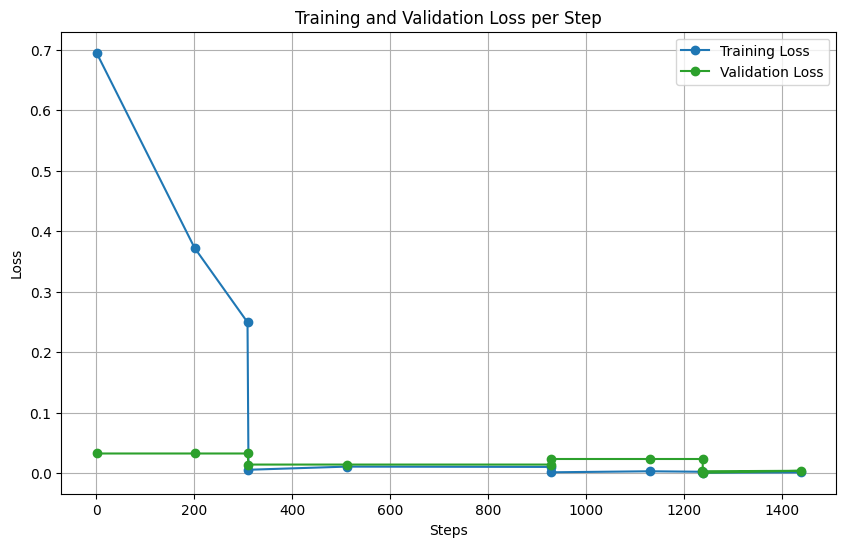

In [30]:
steps_32 = [1, 201, 309, 310 + 1, 310 + 201, 2 * 309 + 310, 2 * 309 + 310 + 1, 
         2 * 309 + 310 + 201, 3 * 309 + 310, 3 * 309 + 310 + 1, 
         3 * 309 + 310 + 201, 4 * 309]

losses = [
    0.6952, 0.3725, 0.2494, 
    0.0055, 0.0107, 0.0102,
    0.0013, 0.0030, 0.0022,
    0.0008, 0.0015, 0.0018
]

val_losses = [
    0.0324, 0.0324, 0.0324, 
    0.0141, 0.0141, 0.0141,
    0.0233, 0.0233, 0.0233,
    0.0006, 0.0038, 0.0030
]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(steps_32, losses, 'o-', label='Training Loss', color='tab:blue')
plt.plot(steps_32, val_losses, 'o-', label='Validation Loss', color='tab:green')

# Etiquetas y título
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Step')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [28]:
model = TransformerClass()

model_save_path = f'..\model_weights\BERT_L_Embedding\model_epoch_2_acc0.9947.pth'
model.load_state_dict(torch.load(model_save_path, weights_only=False))

model.to(device)

TransformerClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [29]:
def test(test_loader, model, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for data in test_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, token_type_ids)
            test_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()

            # Predicciones y probabilidades
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Acumulamos
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Probabilidades de clase positiva
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.argmax(dim=1).cpu().numpy())  # Para multi-clase, usa el índice

            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_test_loss = test_loss / total_predictions
    accuracy = correct_predictions / total_predictions

    # Métricas adicionales
    roc_auc = roc_auc_score(all_targets, all_probs)
    brier = brier_score_loss(all_targets, all_probs)
    f1 = f1_score(all_targets, all_preds, average='weighted')  # Ajusta el promedio si es necesario
    f05 = precision_recall_fscore_support(all_targets, all_preds, average='weighted', beta=0.5)[2]

    # C@1
    correct = sum(1 for t, p in zip(all_targets, all_preds) if t == p)
    c_at_1 = correct / len(all_preds)

    return avg_test_loss, accuracy, roc_auc, brier, c_at_1, f1, f05


# Ejemplo de uso
test_loss, test_accuracy, roc_auc, brier, c_at_1, f1, f05 = test(test_loader, model, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"C@1: {c_at_1:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f05:.4f}")

Test Loss: 0.0145
Test Accuracy: 0.9951
ROC-AUC: 0.9999
Brier Score: 0.0041
C@1: 0.9951
F1 Score: 0.9951
F0.5 Score: 0.9951
